In [2]:
from mb.sql.conn import get_engine, get_session
from mb.sql.basic import read_sql
from mb.sql.utils import list_schemas,list_tables

In [3]:
engine = get_engine(name='postgresql' , db= 'postgres', user='postgres' , password= 'postgres', host= 'localhost', port= 5432, echo=False)
session = get_session(engine)

In [4]:
print(list_schemas(engine),f'\n\n',list_tables(engine, schema='public'))

    schema_name
0  embeddingsDB
1    pg_catalog
2      pg_toast
3        public
4      ytshorts 

        table_name
0     download_db
1  download_queue
2       merged_db
3    mix_video_db
4           test1
5           test3
6   transcript_db


In [5]:
read_sql('''SELECT
    column_name,
    data_type,
    character_maximum_length,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_name = 'download_db'
ORDER BY ordinal_position;''', engine)

,column_name,data_type,character_maximum_length,is_nullable,column_default
0,yt_link,text,None,NO,None
1,local_link,text,None,YES,None
2,download,boolean,None,YES,None
3,date,date,None,YES,None
4,time,time without time zone,None,YES,None


In [6]:
read_sql('SELECT * FROM public.download_db limit 3;', engine)

,yt_link,local_link,download,date,time
0,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:04:29.359650
1,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:13:34.967209
2,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:16:29.363057


In [7]:
data = read_sql('SELECT * FROM public.download_db limit 3;', engine)
print(data.head(2))

                                       yt_link  \
0  https://www.youtube.com/watch?v=_nPQk65D3xE   
1  https://www.youtube.com/watch?v=_nPQk65D3xE   

                                          local_link  download        date  \
0  /home/malav/Desktop/ytshorts_files/yt_download...      True  2025-05-23   
1  /home/malav/Desktop/ytshorts_files/yt_download...      True  2025-05-23   

              time  
0  02:04:29.359650  
1  02:13:34.967209  


In [8]:
from mb.lang.agents.get_langsmith import set_langsmith_parameters

In [9]:
from mb_rag.utils.extra import load_dotenv
load_dotenv()

/home/malav/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


True

In [10]:
set_langsmith_parameters(langsmith_endpoint="https://api.smith.langchain.com",
                        langsmith_project="SQL-Agent-Project",
                        langsmith_tracing="true")

In [11]:
from mb.lang.agents.sql_agents import runtime_sql_agent,run_sql_agent

In [13]:
## testing engine
testing = runtime_sql_agent(engine)
testing.test_basic_mb()


Please install mb_sql package to use test this function: pip install -U mb_sql


'    schema_name\n0  embeddingsDB\n1    pg_catalog\n2      pg_toast\n3        public\n4      ytshorts\n\n       table_name\n0     download_db\n1  download_queue\n2       merged_db\n3    mix_video_db\n4           test1\n5           test3\n6   transcript_db'

In [12]:
from mb_rag.basic import ModelFactory

llm = ModelFactory(model_name="gemini-2.0-flash",model_type='google')
llm.invoke_query('What is the capital of France?')

/home/malav/.local/lib/python3.11/site-packages/pydantic/v1/main.py:1048: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


'The capital of France is **Paris**.'

In [13]:
main_agent = run_sql_agent(llm=llm.model,db_connection=engine,langsmith_params=False,logging=False,user_name="Test_NB_User")

In [14]:
main_agent.run("List all tables in the database.")

================================ Human Message =================================

List all tables in the database.
================================== Ai Message ==================================
Tool Calls:
  get_database_schemas (39b03263-76cf-4fe5-b52c-f0093b2796aa)
 Call ID: 39b03263-76cf-4fe5-b52c-f0093b2796aa
  Args:
================================= Tool Message =================================
Name: get_database_schemas

    schema_name
0  embeddingsDB
1    pg_catalog
2      pg_toast
3        public
4      ytshorts
================================== Ai Message ==================================

OK. I see the schemas are: embeddingsDB, pg_catalog, pg_toast, public, and ytshorts. I will now list the tables in each schema.
Tool Calls:
  list_tables (773a13ec-ec91-4584-a376-0be4b2ceb1bd)
 Call ID: 773a13ec-ec91-4584-a376-0be4b2ceb1bd
  Args:
    schema_name: embeddingsDB
  list_tables (4373b42b-9d01-43bd-8080-fb6c3db4c932)
 Call ID: 4373b42b-9d01-43bd-8080-fb6c3db4c932
  Args:
  

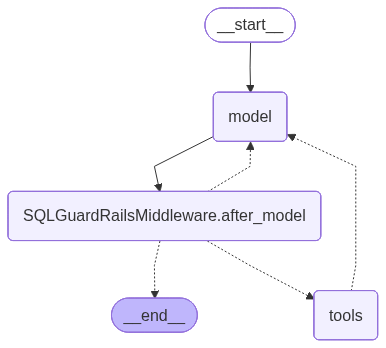

In [16]:
main_agent.agent

In [9]:
from langchain_community.utilities.sql_database import SQLDatabase

In [10]:
db = SQLDatabase(engine=engine)

In [11]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm.model)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [12]:
system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

In [211]:
from langchain_core.callbacks  import BaseCallbackHandler
import time
from langchain.agents.middleware import wrap_model_call, wrap_tool_call,before_model,after_model,AgentMiddleware,AgentState,ModelRequest
from langgraph.runtime import Runtime

# @wrap_tool_call
# class DebugCallback(BaseCallbackHandler):
#     def __init__(self):
#         self.events = []

class LoggingMiddleware(AgentMiddleware):
    
    def before_model(
        self,
        state: AgentState,
        # runtime: Runtime,
        **kwargs,
    ) -> None:
        time_start = time.time()
        print(f"Inputs: {state}")
        state['additional_info'] = time_start
        print(f'New Info added to state:{state}')
        # print(f"Runtime complete: {runtime}")
        # print(f"Runtime info: {runtime.context.name}, {runtime.context.additional_info}")
        time_end = time.time()
        print(f"Time taken: {time_end - time_start} seconds")
        return None

    def after_model(self, state, runtime):
        # time_end = time.time()
        # time_start = state.get('additional_info', time_end)
        print(f"Model response: {state}")
        # print(f"Runtime info: {runtime.context.name}, {runtime.context.additional_info}")
        # print(f"Time taken: {time_end - time_start} seconds")
        return None

    def after_agent(self, state: AgentState, **kwargs) -> None:
        time_end = time.time()
        print(f"Agent ended. Time taken: {time_end - time.time()} seconds")
        print(f"Final state: {state}")
        return None
    
    def model_request(
        self,
        state: AgentState,
        request: ModelRequest,
        **kwargs,
    ) -> ModelRequest:
        print(f"Model request: {request}")
        return request


# @wrap_tool_call
@before_model
def on_chain_start(reqest, run_id=None, parent_run_id=None, tags=None, metadata=None, **kwargs):
    # print(f"Chain started with run_id: {run_id}")
    print(f'Time start : {time.time()}')
    time_start = time.time()
    print(f"Inputs: {reqest}")
    time_end = time.time()
    print(f"Time taken: {time_end - time_start} seconds")
    # return None
    # print(f"Inputs: {inputs}")
    # events= []
    # events.append({
    #     "event": "start",
    #     "run_id": run_id,
    #     "start_time": time.time(),
    #     "input": inputs,
    #     "metadata": metadata,
    # })

# @after_model(can_jump_to=['end'])
# @after_model(can_jump_to=['end'])
# def on_chain_end(outputs, run_id):
#     # print(f"Chain ended with outputs: ")
#     print(f"Outputs: {outputs}")
#     print(f"Run ID: {run_id}")

# callback = DebugCallback()

In [203]:
class Context:
    def __init__(self,name:str,additional_info:dict=None,table_info:str=None):
        self.name = name
        self.additional_info = additional_info
        self.table_info = table_info

In [258]:
from langchain.agents import create_agent

agent = create_agent(
    llm.model,
    tools,
    system_prompt=system_prompt,
    debug=False,
    middleware=[LoggingMiddleware(),SQLGuardRailsMiddleware()],
    # context_schema=db
    # context_schema=Context
)

In [261]:
question = "Give me 5 results of download_db?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    # context=Context(name="SQL_context_check", additional_info={"Test": "123"},table_info="download_db"),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Give me 5 results of download_db?
Inputs: {'messages': [HumanMessage(content='Give me 5 results of download_db?', additional_kwargs={}, response_metadata={}, id='74c59b7d-9788-4c95-bc61-62fb6b7b9ade')]}
New Info added to state:{'messages': [HumanMessage(content='Give me 5 results of download_db?', additional_kwargs={}, response_metadata={}, id='74c59b7d-9788-4c95-bc61-62fb6b7b9ade')], 'additional_info': 1762923487.0182188}
Time taken: 9.226799011230469e-05 seconds
================================== Ai Message ==================================

I need to know what tables are available in the database before I can query the `download_db` table.
Tool Calls:
  sql_db_list_tables (16db7fcb-fc22-401b-be43-3b3a16dadb4d)
 Call ID: 16db7fcb-fc22-401b-be43-3b3a16dadb4d
  Args:
[SQLGuardRailsMiddleware] Inspecting query: 
Model response: {'messages': [HumanMessage(content='Give me 5 results of download_db?', additi

In [23]:
from mb_rag.utils.viewer import display_graph_png

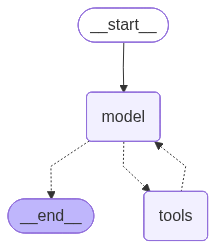

In [65]:
display_graph_png(agent)